# Capstone Project - Traffic Sign Recognition Using Convolutional Neural Network

## Background

Reading traffic signs is an important component of autonomous driving. Autonomous cars need to be able to see the road signs just for the same reasons humans need them. They allow the driver to know the speed they should be traveling, where to stop, and what to be cautious of on the road ahead. Automotive companies could use traffic sign recognition as an aid to human-driven cars as well. Sometimes a human driver can miss a sign alerting them to an upcoming curve or a speed limit change, and the car could remind the driver if it doesn't sense proper responses to signage.

The data to be used for this project comes from the Institute for Neuroinformatik.  It contains 35,000 training images and 12,000 test images of 43 classes of German traffic signs.  The images are 32 x 32 pixels and have 3 color channels. This data can be accessed at the INI website at http://benchmark.ini.rub.de/?section=gtsrb&subsection=news.


## Load and Inspect Data

In [1]:
# Load Required Packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pickle
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import pandas as pd
from sklearn.utils import shuffle

In [2]:
# Load pickled Data
training_file = "./traffic-signs-data/train.p"
validation_file= "./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)

image_shape = (X_train[0].shape)

unique, index, counts = np.unique(y_train, return_index = True, return_counts=True)

n_classes = len(unique)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


#### Plot Examples of Each Class

I'll define a function `plot_class_examples` that will plot 10 samples from each class in the training data.

In [4]:
def plot_class_examples(x, y):

    import random
    classes, counts = np.unique(y, return_counts=True)
    num_classes = len(classes)
    image_shape = x[0].shape
    num_channel = image_shape[2]
    sign_class_names = pd.read_csv("sign_class_names.csv").values[:, 1]
    col_width = max(len(name) for name in sign_class_names)

    for i in range(num_classes):
        
        indexes = y == i   #Creates boolean array lenth 34,799
        count = np.sum(indexes)  # Counts total of samples per class for each iteration
        x_samples = x[indexes]  #Creates a 4d numpy array of the iteration's class
        class_count = len(x_samples)
        print("Class %i: %-*s  %s samples" % (i, col_width, sign_class_names[i], str(class_count)))
        
        fig = plt.figure(figsize = (6, 1))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
        random_indices = random.sample(range(class_count), 10)
        
        for i in range(10):
            if num_channel == 1:
                axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
                axis.imshow(x_samples[random_indices[i]].reshape(32,32), cmap = 'gray')
            else:
                axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
                axis.imshow(x_samples[random_indices[i]].reshape(32,32,num_channel))
            
        plt.show()
        print("______________________________________________________________________________________\n")

Class 0: Speed limit  (20km/h)                               180 samples


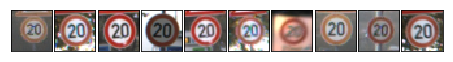

______________________________________________________________________________________

Class 1: Speed limit  (30km/h)                               1980 samples


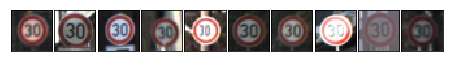

______________________________________________________________________________________

Class 2: Speed limit  (50km/h)                               2010 samples


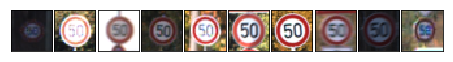

______________________________________________________________________________________

Class 3: Speed limit  (60km/h)                               1260 samples


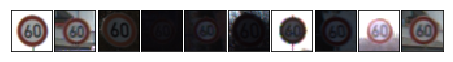

______________________________________________________________________________________

Class 4: Speed limit  (70km/h)                               1770 samples


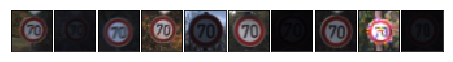

______________________________________________________________________________________

Class 5: Speed limit  (80km/h)                               1650 samples


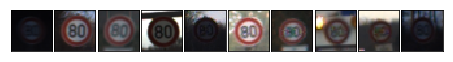

______________________________________________________________________________________

Class 6: End of speed limit  (80km/h)                        360 samples


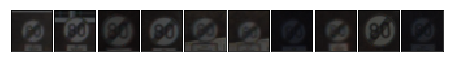

______________________________________________________________________________________

Class 7: Speed limit  (100km/h)                              1290 samples


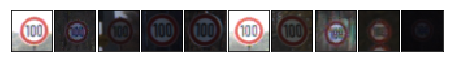

______________________________________________________________________________________

Class 8: Speed limit  (120km/h)                              1260 samples


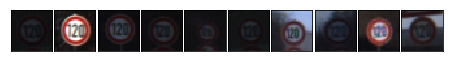

______________________________________________________________________________________

Class 9: No passing                                          1320 samples


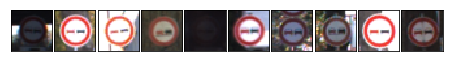

______________________________________________________________________________________

Class 10: No passing for vehicles over 3.5 metric tons        1800 samples


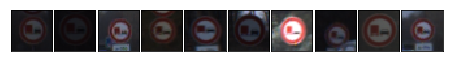

______________________________________________________________________________________

Class 11: Right-of-way at the next intersection               1170 samples


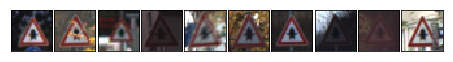

______________________________________________________________________________________

Class 12: Priority road                                       1890 samples


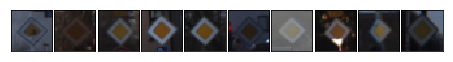

______________________________________________________________________________________

Class 13: Yield                                               1920 samples


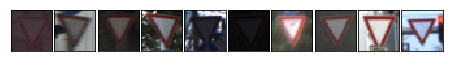

______________________________________________________________________________________

Class 14: Stop                                                690 samples


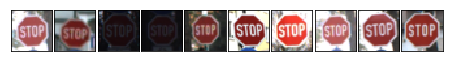

______________________________________________________________________________________

Class 15: No vehicles                                         540 samples


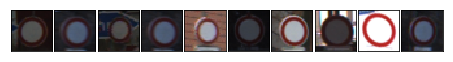

______________________________________________________________________________________

Class 16: Vehicles over 3.5 metric tons prohibited            360 samples


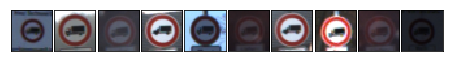

______________________________________________________________________________________

Class 17: no entry                                            990 samples


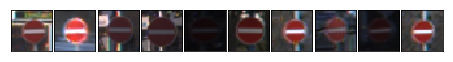

______________________________________________________________________________________

Class 18: general caution                                     1080 samples


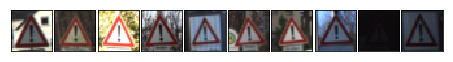

______________________________________________________________________________________

Class 19: Dangerous curve to the left                         180 samples


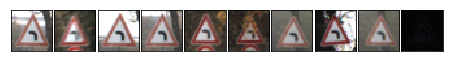

______________________________________________________________________________________

Class 20: Dangerous curve to the right                        300 samples


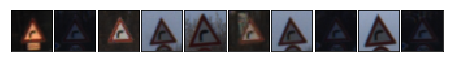

______________________________________________________________________________________

Class 21: Double Curve                                        270 samples


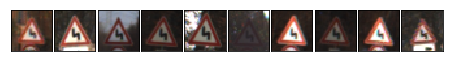

______________________________________________________________________________________

Class 22: Bumpy road                                          330 samples


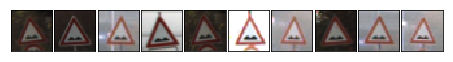

______________________________________________________________________________________

Class 23: Slippery road                                       450 samples


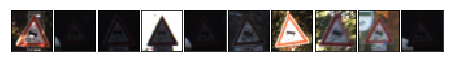

______________________________________________________________________________________

Class 24: Road narrows on the right                           240 samples


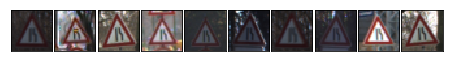

______________________________________________________________________________________

Class 25: Road work                                           1350 samples


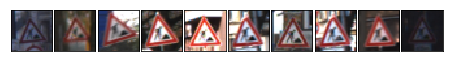

______________________________________________________________________________________

Class 26: Traffic signals                                     540 samples


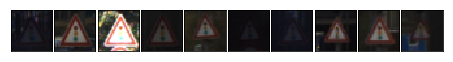

______________________________________________________________________________________

Class 27: Pedestrians                                         210 samples


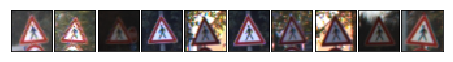

______________________________________________________________________________________

Class 28: Childen crossing                                    480 samples


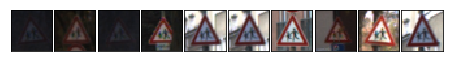

______________________________________________________________________________________

Class 29: Bicycles crossing                                   240 samples


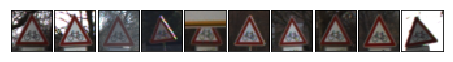

______________________________________________________________________________________

Class 30: Beware of ice/snow                                  390 samples


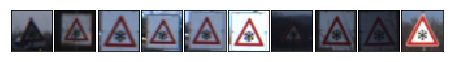

______________________________________________________________________________________

Class 31: Wild animals crossing                               690 samples


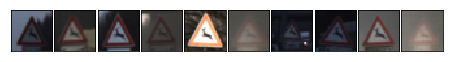

______________________________________________________________________________________

Class 32: End of all speed and passing limits                 210 samples


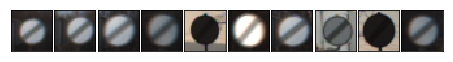

______________________________________________________________________________________

Class 33: Turn right ahead                                    599 samples


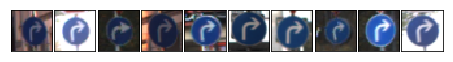

______________________________________________________________________________________

Class 34: Turn left ahead                                     360 samples


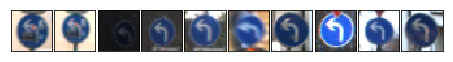

______________________________________________________________________________________

Class 35: Ahead Only                                          1080 samples


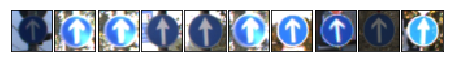

______________________________________________________________________________________

Class 36: Go stright or right                                 330 samples


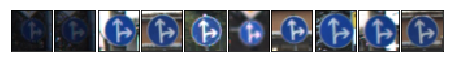

______________________________________________________________________________________

Class 37: Go straight or left                                 180 samples


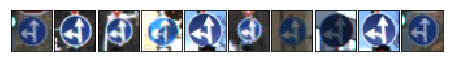

______________________________________________________________________________________

Class 38: Keep right                                          1860 samples


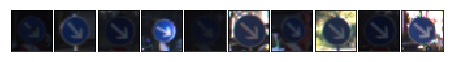

______________________________________________________________________________________

Class 39: Keep left                                           270 samples


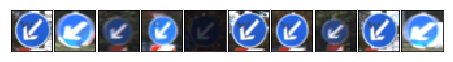

______________________________________________________________________________________

Class 40: Roundabout mandatory                                300 samples


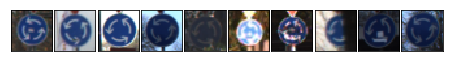

______________________________________________________________________________________

Class 41: End of no passing                                   210 samples


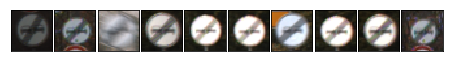

______________________________________________________________________________________

Class 42: End of no passing by vehicles over 3.5 metric tons  210 samples


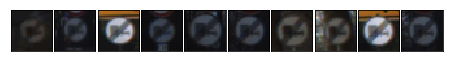

______________________________________________________________________________________



In [5]:
plot_class_examples(X_train, y_train)

There is not a lot of training data given the number of classes, and a lot of classes only have a few hundred training images.

The images appear to be well centered, with small degrees of rotation present. 

There is a large variation in brightness, with some images looking washed out, and others almost too dark to recognize.

## Data Preprocessing

I will take some initial image data preprocessing steps.  I will convert the images to grayscale, create some additional training images, and perform histogram equalization.

#### Convert to Grayscale

The images have three color channels, but many of the signs use the same color schemes and there is a higher variety of colors in the backgrounds than in the signs themselves, which may just add noise.  I will convert the images to grayscale for the initial modeling.

In [6]:
# Saving the 3-channel data in case it is needed later.
X_train_3c = X_train
X_valid_3c = X_valid
X_test_3c = X_test

Next I will define a function `rbg_to_gray` that will convert the 3-color image arrays into grayscale, then convert the data to grayscale.

In [7]:
def rgb_to_gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114]).reshape((-1,32,32,1))
    

X_train = rgb_to_gray(X_train)
X_valid = rgb_to_gray(X_valid)
X_test = rgb_to_gray(X_test)

print(X_train.shape, X_train.dtype)
print(X_valid.shape, X_valid.dtype)
print(X_test.shape, X_test.dtype)

(34799, 32, 32, 1) float64
(4410, 32, 32, 1) float64
(12630, 32, 32, 1) float64


#### Class Imbalance

There are 34,770 training images.  First I'll to plot the number of images by class to see how imbalanced the classes are.

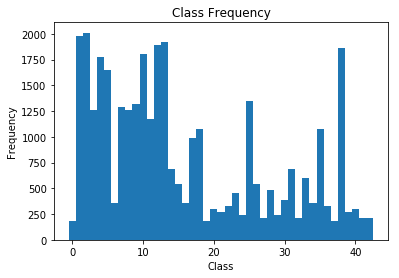

Maximum Class Count:  2010
Minimum Class Count:  180


In [8]:
n_classes, index, counts = np.unique(y_train, return_index = True, return_counts=True)

plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

print("Maximum Class Count: ", max(counts))
print("Minimum Class Count: ", min(counts))

There are quite a few classes with fewer than 500 training images, with some having as few as 180.  To generate additional training images, I will define a function to upsample the under-represented classes. I will sample the existing data with replacement, and for each new sample I will add a random rotation between -5 and +5 degrees.

#### Generate Additional Training Data

In [9]:
from scipy.ndimage import rotate

def generate_additional_data_rotate(x, y, angle):
    """Takes 4d numpy array of images x and class labels y,
    determines how many additional images per class to generate so that
    all classes have the same number of images, then generates additional
    images with rotation specified"""
    
    # Calculate number of classes and and image counts for classes
    classes, counts = np.unique(y, return_counts=True)
    num_classes = len(classes)
    # Determine maximum class count
    max_class_count = max(counts)
    
    # Calculate number of new images needed to give all classes an image count
    # equal to that of the class with the highest count
    num_samples = len(x)
    num_new_images = int((num_classes * max_class_count) - num_samples)
    
    # Create empty numpy arrays to fill with new images and labels
    x_additional = np.empty(shape = (num_new_images,32,32,1))
    y_additional = np.empty(shape = (num_new_images,))
    
    # Initialize index to iterate over for new array
    new_array_index = 0
    
    # Iterate over each class
    for i in range(num_classes):
        
        #Boolean array of input, True if this class
        indexes = y == i   
        
        # Total image count for this class
        count = np.sum(indexes)  
        
        #Create a 4d numpy array of the iteration's class
        x_train_samples = x[indexes]  
        
        # creates 1d array of iteration's class 
        y_train_samples = y[indexes]
        
        # Calculate  number of new samples to generate 
        num_new_samples = max_class_count - count
        
        # Loop over number of new samples for each class
        for i in range(num_new_samples):
            
            # Pulls a random number from number of images in class
            sample_index = np.random.choice(count)
            # Creates a sample image
            x_sample = x_train_samples[sample_index]
            # Create a random angle +- angle input
            random_angle = (angle * 2) * np.random.random_sample(1) - angle
            # Create new image adding rotation to sample image.
            x_new = rotate(x_sample, random_angle, axes=(0,1), reshape=False, mode = 'nearest')
            # Create new label
            y_new = y_train_samples[0].reshape(1,)
            #adds new image to next spot in empty array
            x_additional[new_array_index] = x_new
            #adds new label to next spot in empty array
            y_additional[new_array_index] = y_new
            # reset new_arraw_inex to next empty spot
            new_array_index += 1

    return x_additional, y_additional

In [10]:
X_train_new, y_train_new = generate_additional_data_rotate(X_train, y_train, 5)

In [11]:
# Add generated images and labels to existing data.
X_train = np.concatenate((X_train, X_train_new))
y_train = np.concatenate((y_train, y_train_new))

In [12]:
# Calculate Some summary information for the data
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)

image_shape = (X_train[0].shape)
img_size = (X_train[0].shape)

unique, index, counts = np.unique(y_train, return_index = True, return_counts=True)

n_classes = len(unique)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 86430
Number of testing examples = 12630
Image data shape = (32, 32, 1)
Number of classes = 43


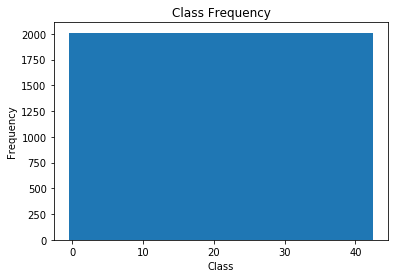

In [13]:
# plot class frequency agian to check for class balance
n_classes, index, counts = np.unique(y_train, return_index = True, return_counts=True)

plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

Classes are now balanced, with 2010 images each.

#### Prepare Training Data for Modelling

In [14]:
# Convert to type uint8
X_train = X_train.astype(np.uint8)
y_train = y_train.astype(np.uint8)
X_valid = X_valid.astype(np.uint8)
y_valid = y_valid.astype(np.uint8)

In [15]:
# Function to convert labels into one hot array
def one_hot_array(nparray):
    one_hot_array = np.zeros((nparray.size, nparray.max()+1))
    one_hot_array[np.arange(nparray.size), nparray] = 1
    return one_hot_array

In [16]:
# Create one hot arrays for target variables
y_train_2 = one_hot_array(y_train)
y_test_2 = one_hot_array(y_test)

In [17]:
print(y_train_2.shape, y_train_2.dtype)
print(y_test_2.shape, y_test_2.dtype)

(86430, 43) float64
(12630, 43) float64


In [18]:
# Create variables for image size, number of classes and channels which will be used in later functions.
img_size = X_train.shape[1]
num_classes = len(unique)
num_channels = X_train.shape[3]


## TensorFlow Graph Building Functions

#### Function to Generate New Weights

In [19]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

#### Function to Generate New Convolutional Layer

The function `new_conv_layer` takes the previous layer as input, the number of channels in the previous layer, filter size and nuber of filters, as well as the option to use pooling.

In [20]:
def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   use_pooling=True):
    
    # Shape of the filters and weights as needed for TensorFlow
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Creates new weights of the correct chape using new_weights function
    weights = new_weights(shape=shape)

    # Creates new biases with one for each filter.
    biases = new_biases(length=num_filters)

    # Create Tensorflow  2D Convolutional layer
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')

    # Add biases to the layer
    layer += biases

    # 2 x 2 pooling to down-sample image resolution (Optional)
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Function to apply to output.    
    layer = tf.nn.relu(layer)

    return layer, weights

#### Function to Create Flattenening Later

In [21]:
# Turns 4D output into 2D

def flatten_layer(layer):
    # Get shape of input layer
    layer_shape = layer.get_shape()
    
    # TensorFlow function to get number of features
    num_features = layer_shape[1:4].num_elements()
    
    # Use reshape to flatten
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    # Return the flattened layer and the number of features
    return layer_flat, num_features

#### Function to Create New Fully Connected later

In [22]:
def new_fully_conn_layer(input,
                         num_inputs,
                         num_outputs,
                         use_relu = True):

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

## Placeholder Variables

In [23]:
# For input images
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 1], name='x')

x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

# Placeholder variable for the true labels associated with images in input placeholder variable x.
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

y_true_class = tf.argmax(y_true, axis=1)

## Additional Functions for Running Tensorflow

#### Optimizer Function

This is the function that will train the neural network. Due to the number of training images, the optimize function will only will pull a random sample of images for each training iteration, feed them through the neural network and update the weights.

In [24]:
# Counter to count how many optimization iterations have been ran.
total_iterations = 0

def optimize(num_iterations):
    # To update the the global variable rather than local copy
    global total_iterations
    
    num_examples = len(X_train)
    start_time = time.time()
    
    for i in range(total_iterations, total_iterations + num_iterations):
        
        x_batch, y_true_batch = shuffle(X_train,y_train_2)
        
        batch_x, batch_y = x_batch[0 : train_batch_size], y_true_batch[0 : train_batch_size]
            
        feed_dict_train = {x: batch_x,
                          y_true: batch_y}
        
        session.run(optimizer, feed_dict=feed_dict_train)
        
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            message = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            
            print(message.format(i + 1, acc))
            
    total_iterations += num_iterations
    
    end_time = time.time()
    
    time_diff = end_time - start_time
    
    print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))

#### Function to Plot example errors

In [25]:
def plot_example_errors(class_pred, correct):
    
    incorrect = (correct == False)
    
    images = X_test[incorrect]
    
    class_pred = class_pred[incorrect]
    
    class_true = y_test[incorrect]
    
    plot_images(images=images[0:9],
               class_true=class_true[0:9],
               class_pred=class_pred[0:9])

#### Function to Print Test Accuracy

The `print_test_accuracy` function can be called periodically to see how well the netowrk is predicting the test data. There is an option to show examples of prediction errors and confusion matrix, which will use functions defined below.

In [26]:
# Split the test-set into smaller batches of this size.
test_batch_size = 32

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(y_test)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    class_pred = np.zeros(shape=num_test, dtype=np.int)

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        images = X_test[i:j, :]

        labels = y_test_2[i:j, :]

        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        class_pred[i:j] = session.run(y_pred_class, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    class_true = y_test 

    # Create a boolean array whether each image is correctly classified.
    correct = (class_true == class_pred)

    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(class_pred=class_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(class_pred=class_pred)

#### Function to Plot Confusion Matrix

In [27]:
def plot_confusion_matrix(class_pred):
    
    class_true  = y_test
    
    cm = confusion_matrix(y_true=class_true,
                         y_pred=class_pred)
    
    print(cm)
    
    plt.figure(figsize=(11,11))
    plt.matshow(cm, fignum=1)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

#### Function to Plot Images

In [28]:
def plot_images(images, class_true, class_pred=None):
    assert len(images) == len(class_true) == 9
    image_shape = images[0].shape
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(32,32), cmap='binary')

        # Show true and predicted classes.
        if class_pred is None:
            xlabel = "True: {0}".format(class_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(class_true[i], class_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Building the TensorFlow Graphs

### Architecture 1

The initial model architecture I used is based on the LeNet-5 architecture, which was originated in the 1990s for recognizing handwritten digits. The architechture includes 2 convolutional layers with 5x5 filters and pooling, followed by a flattening layer and 3 fully connected layers, the last of which is the output layer.

#### Hyperparameters

In [29]:
# Configuration of Neural Network

# Convolutional Layer 1
filter_size1 = 5
num_filters1 = 16

# Convolutional Layer 2
filter_size2 = 5
num_filters2 = 36

# Fully Connected Layer 1
fc_size = 516

# Fully Connected Layer 2
fc2_size = 360

# Fully Connected Layer 3 - Output
fc3_size = 43

# Train Batch Size
train_batch_size = 64

# Learning Rate
learning_rate = 0.0001

####  Building Model Architecture 1

In [30]:
# Convolutional Layer 1
conv_layer_1, conv_weights_1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

print(conv_layer_1)

# Convolutional Layer 2
conv_layer_2, conv_weights_2 = \
    new_conv_layer(input=conv_layer_1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)


# Flattening Layer
layer_flat, num_features = flatten_layer(conv_layer_2)


# Fully Connected Layer 1
fully_conn_layer_1 = new_fully_conn_layer(input=layer_flat,
                                          num_inputs=num_features,
                                          num_outputs=fc_size,
                                          use_relu=True)

# Fully Connected Layer 2
fully_conn_layer_2 = new_fully_conn_layer(input=fully_conn_layer_1,
                                          num_inputs=fc_size,
                                          num_outputs=fc2_size,
                                          use_relu=True)

# Fully Connected Layer 3 - Output Layer
fully_conn_layer_3 = new_fully_conn_layer(input= fully_conn_layer_2,
                                          num_inputs=fc2_size,
                                          num_outputs=fc3_size,
                                          use_relu=False)

# Predicted Class
y_pred = tf.nn.softmax(fully_conn_layer_3)
y_pred_class = tf.argmax(y_pred, axis=1)


# Cost Function to be Optimazed - Softmax Cross Entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=fully_conn_layer_3,
                                                       labels=y_true)
cost = tf.reduce_mean(cross_entropy)


# Optimization Method - Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


# Performance Measures
correct_prediction = tf.equal(y_pred_class, y_true_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


print(conv_layer_1)
print(conv_layer_2)
print(layer_flat)
print(fully_conn_layer_1)
print(fully_conn_layer_2)
print(fully_conn_layer_3)
print(y_pred_class)
print(cost)

Tensor("Relu:0", shape=(?, 16, 16, 16), dtype=float32)
Tensor("Relu:0", shape=(?, 16, 16, 16), dtype=float32)
Tensor("Relu_1:0", shape=(?, 8, 8, 36), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 2304), dtype=float32)
Tensor("Relu_2:0", shape=(?, 516), dtype=float32)
Tensor("Relu_3:0", shape=(?, 360), dtype=float32)
Tensor("add_4:0", shape=(?, 43), dtype=float32)
Tensor("ArgMax_1:0", shape=(?,), dtype=int64)
Tensor("Mean:0", shape=(), dtype=float32)


## Run TensorFlow

In [31]:
session = tf.Session()
session.run(tf.global_variables_initializer())

### Begin Training Iterations - 1st Architecture

#### 100 Iterations

In [32]:
optimize(num_iterations=100)

Optimization Iteration:      1, Training Accuracy:   9.4%
Time usage: 0:00:37


Accuracy on Test-Set: 12.8% (1613 / 12630)
Confusion Matrix:
[[  7   1   6 ...   3   4   0]
 [109  75  50 ...   8   7   1]
 [ 69  35 105 ...   7  49   0]
 ...
 [ 19   1   0 ...  11   0   0]
 [  0   0   0 ...   0  23   0]
 [  2   2   1 ...   6  58   0]]


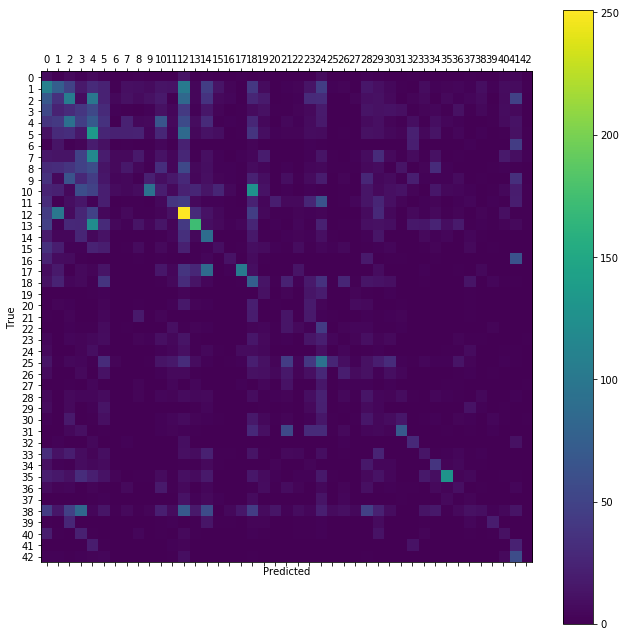

100


In [33]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

Even after only 100 training iterations, a faint diagonal line is starting to form in the confusion matrix. Next I will see how things look after 1000 iterations.

#### 1000 Iterations

In [34]:
optimize(num_iterations=900)

Optimization Iteration:    101, Training Accuracy:  21.9%
Optimization Iteration:    201, Training Accuracy:  39.1%
Optimization Iteration:    301, Training Accuracy:  53.1%
Optimization Iteration:    401, Training Accuracy:  65.6%
Optimization Iteration:    501, Training Accuracy:  85.9%
Optimization Iteration:    601, Training Accuracy:  75.0%
Optimization Iteration:    701, Training Accuracy:  87.5%
Optimization Iteration:    801, Training Accuracy:  87.5%
Optimization Iteration:    901, Training Accuracy:  87.5%
Time usage: 0:05:20


Accuracy on Test-Set: 67.2% (8487 / 12630)
Example errors:


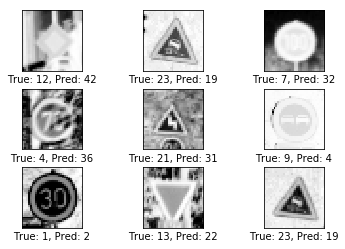

Confusion Matrix:
[[ 14  24   2 ...   0   0   0]
 [ 54 471  81 ...   1   0   0]
 [ 24  66 519 ...   4   0   3]
 ...
 [  0   1   0 ...  53   0   0]
 [  0   0   0 ...   0  25  10]
 [  0   0   0 ...   1   0  78]]


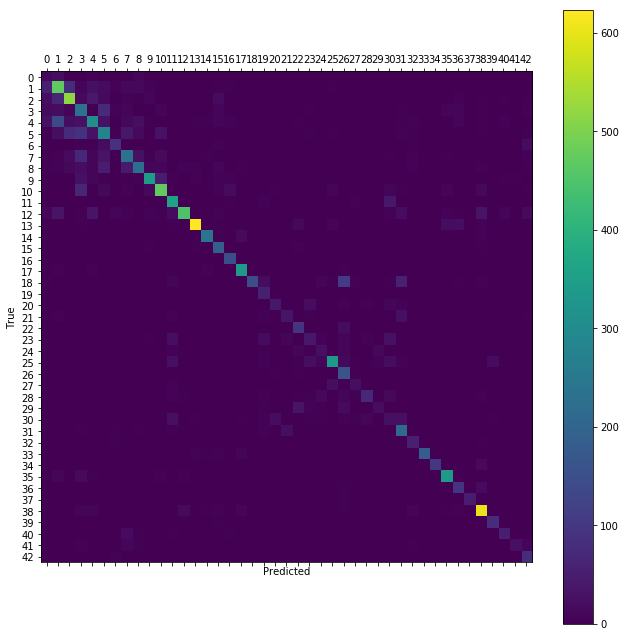

1000


In [35]:
print_test_accuracy(show_confusion_matrix=True, show_example_errors = True)
print(total_iterations)

#### 5000 Iterations

In [36]:
optimize(num_iterations=4000)

Optimization Iteration:   1001, Training Accuracy:  87.5%
Optimization Iteration:   1101, Training Accuracy:  90.6%
Optimization Iteration:   1201, Training Accuracy:  96.9%
Optimization Iteration:   1301, Training Accuracy:  87.5%
Optimization Iteration:   1401, Training Accuracy:  89.1%
Optimization Iteration:   1501, Training Accuracy:  98.4%
Optimization Iteration:   1601, Training Accuracy:  95.3%
Optimization Iteration:   1701, Training Accuracy: 100.0%
Optimization Iteration:   1801, Training Accuracy:  93.8%
Optimization Iteration:   1901, Training Accuracy:  93.8%
Optimization Iteration:   2001, Training Accuracy:  96.9%
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy:  98.4%
Optimization Iteration:   2301, Training Accuracy:  95.3%
Optimization Iteration:   2401, Training Accuracy:  98.4%
Optimization Iteration:   2501, Training Accuracy:  93.8%
Optimization Iteration:   2601, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 84.5% (10671 / 12630)
Confusion Matrix:
[[ 18   5   0 ...   0   0   0]
 [  9 555  40 ...   0   1   0]
 [  1  13 651 ...   0   0   0]
 ...
 [  0   0   0 ...  56   0   0]
 [  0   0   0 ...   0  36   0]
 [  0   0   0 ...   0   9  78]]


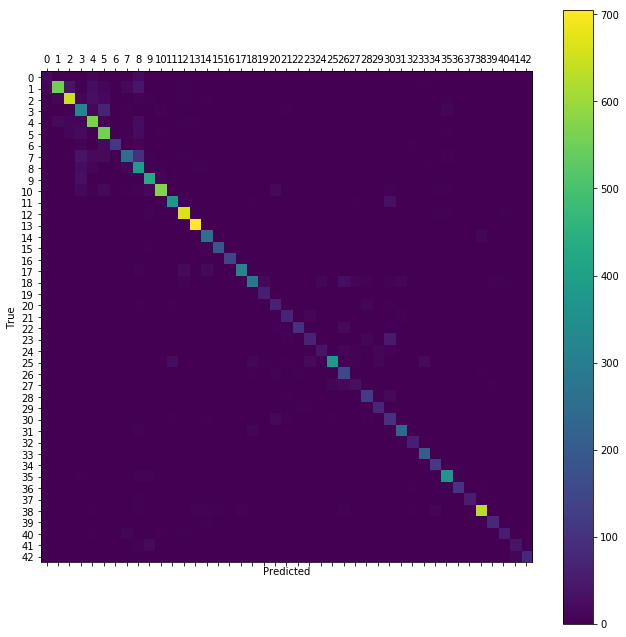

5000


In [37]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

#### 10000 Iterations

In [38]:
optimize(num_iterations=5000)

Optimization Iteration:   5001, Training Accuracy: 100.0%
Optimization Iteration:   5101, Training Accuracy: 100.0%
Optimization Iteration:   5201, Training Accuracy: 100.0%
Optimization Iteration:   5301, Training Accuracy: 100.0%
Optimization Iteration:   5401, Training Accuracy: 100.0%
Optimization Iteration:   5501, Training Accuracy: 100.0%
Optimization Iteration:   5601, Training Accuracy: 100.0%
Optimization Iteration:   5701, Training Accuracy: 100.0%
Optimization Iteration:   5801, Training Accuracy: 100.0%
Optimization Iteration:   5901, Training Accuracy:  96.9%
Optimization Iteration:   6001, Training Accuracy:  98.4%
Optimization Iteration:   6101, Training Accuracy: 100.0%
Optimization Iteration:   6201, Training Accuracy: 100.0%
Optimization Iteration:   6301, Training Accuracy: 100.0%
Optimization Iteration:   6401, Training Accuracy:  98.4%
Optimization Iteration:   6501, Training Accuracy: 100.0%
Optimization Iteration:   6601, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 88.0% (11111 / 12630)
Confusion Matrix:
[[ 32  21   0 ...   0   0   0]
 [  6 663  40 ...   0   0   0]
 [  0   9 705 ...   0   0   0]
 ...
 [  0   0   0 ...  67   0   0]
 [  0   0   0 ...   0  38   0]
 [  0   0   0 ...   0   2  85]]


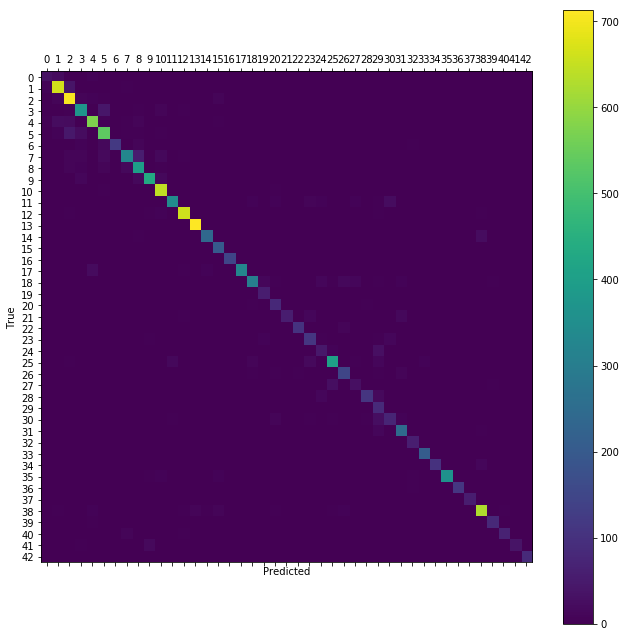

10000


In [39]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

#### 20000 Iterations

In [40]:
optimize(num_iterations=10000)

Optimization Iteration:  10001, Training Accuracy: 100.0%
Optimization Iteration:  10101, Training Accuracy: 100.0%
Optimization Iteration:  10201, Training Accuracy: 100.0%
Optimization Iteration:  10301, Training Accuracy: 100.0%
Optimization Iteration:  10401, Training Accuracy: 100.0%
Optimization Iteration:  10501, Training Accuracy: 100.0%
Optimization Iteration:  10601, Training Accuracy: 100.0%
Optimization Iteration:  10701, Training Accuracy: 100.0%
Optimization Iteration:  10801, Training Accuracy: 100.0%
Optimization Iteration:  10901, Training Accuracy: 100.0%
Optimization Iteration:  11001, Training Accuracy: 100.0%
Optimization Iteration:  11101, Training Accuracy: 100.0%
Optimization Iteration:  11201, Training Accuracy: 100.0%
Optimization Iteration:  11301, Training Accuracy: 100.0%
Optimization Iteration:  11401, Training Accuracy: 100.0%
Optimization Iteration:  11501, Training Accuracy: 100.0%
Optimization Iteration:  11601, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 90.9% (11485 / 12630)
Confusion Matrix:
[[ 40  10   0 ...   0   0   0]
 [  0 702   6 ...   0   0   0]
 [  0  16 697 ...   1   0   1]
 ...
 [  0   0   0 ...  74   0   0]
 [  0   0   0 ...   0  36   0]
 [  0   0   0 ...   0   0  85]]


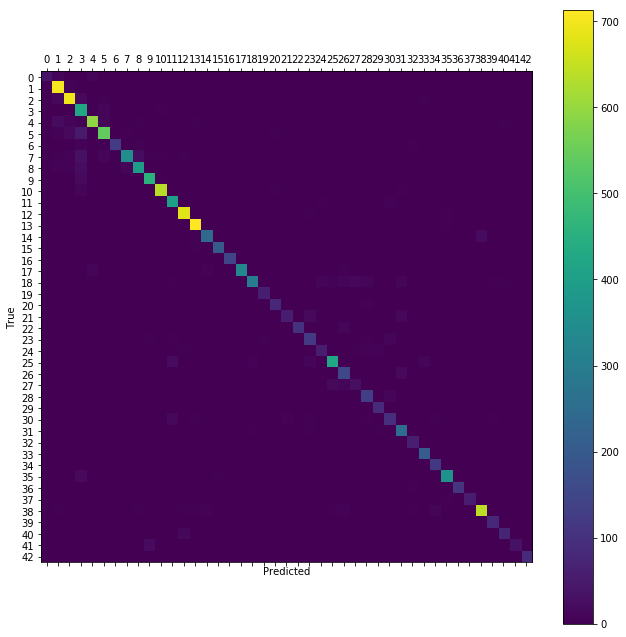

20000


In [41]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

#### 30000 Iterations

In [42]:
optimize(num_iterations=10000)

Optimization Iteration:  20001, Training Accuracy: 100.0%
Optimization Iteration:  20101, Training Accuracy: 100.0%
Optimization Iteration:  20201, Training Accuracy: 100.0%
Optimization Iteration:  20301, Training Accuracy: 100.0%
Optimization Iteration:  20401, Training Accuracy: 100.0%
Optimization Iteration:  20501, Training Accuracy: 100.0%
Optimization Iteration:  20601, Training Accuracy: 100.0%
Optimization Iteration:  20701, Training Accuracy: 100.0%
Optimization Iteration:  20801, Training Accuracy: 100.0%
Optimization Iteration:  20901, Training Accuracy: 100.0%
Optimization Iteration:  21001, Training Accuracy: 100.0%
Optimization Iteration:  21101, Training Accuracy: 100.0%
Optimization Iteration:  21201, Training Accuracy:  98.4%
Optimization Iteration:  21301, Training Accuracy: 100.0%
Optimization Iteration:  21401, Training Accuracy: 100.0%
Optimization Iteration:  21501, Training Accuracy: 100.0%
Optimization Iteration:  21601, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 91.1% (11509 / 12630)
Confusion Matrix:
[[ 56   1   0 ...   0   0   0]
 [ 31 645  13 ...   0   0   0]
 [  0   8 713 ...   0   0   0]
 ...
 [  0   0   0 ...  66   0   0]
 [  0   0   0 ...   0  50   0]
 [  0   0   0 ...   0   1  85]]


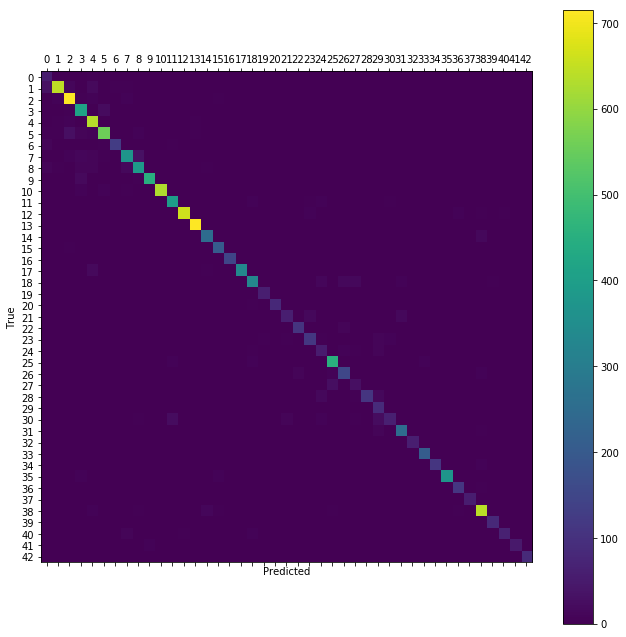

30000


In [43]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

#### 40000 Iterations

In [44]:
optimize(num_iterations=10000)

Optimization Iteration:  30001, Training Accuracy: 100.0%
Optimization Iteration:  30101, Training Accuracy: 100.0%
Optimization Iteration:  30201, Training Accuracy: 100.0%
Optimization Iteration:  30301, Training Accuracy: 100.0%
Optimization Iteration:  30401, Training Accuracy: 100.0%
Optimization Iteration:  30501, Training Accuracy: 100.0%
Optimization Iteration:  30601, Training Accuracy: 100.0%
Optimization Iteration:  30701, Training Accuracy: 100.0%
Optimization Iteration:  30801, Training Accuracy: 100.0%
Optimization Iteration:  30901, Training Accuracy: 100.0%
Optimization Iteration:  31001, Training Accuracy: 100.0%
Optimization Iteration:  31101, Training Accuracy: 100.0%
Optimization Iteration:  31201, Training Accuracy: 100.0%
Optimization Iteration:  31301, Training Accuracy: 100.0%
Optimization Iteration:  31401, Training Accuracy: 100.0%
Optimization Iteration:  31501, Training Accuracy: 100.0%
Optimization Iteration:  31601, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 91.8% (11597 / 12630)
Confusion Matrix:
[[ 46   1   0 ...   0   0   0]
 [  1 673  12 ...   0   0   0]
 [  0   9 701 ...   1   0   0]
 ...
 [  0   0   1 ...  78   0   0]
 [  0   0   0 ...   0  48   0]
 [  0   0   0 ...   0   0  86]]


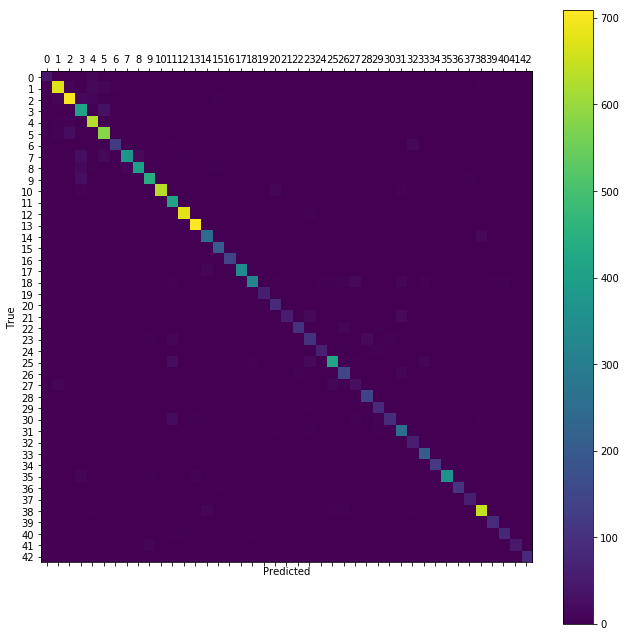

40000


In [46]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

### Architecture 2

The second model architecture I used is based on the VGGNet architecture, which was first introduced in 2014.  The VGGNet is deeper than the LeNet-5 architecture, typically having 16-19 layers. VGGNet uses 3x3 filters, and 13 convolutional layers, with pooling occurring after layers 2, 4, 7, 10, and 13. These layers are followed by 2 fully connected layers and the output layer.

Since I am working with smaller images, I was not able to make the network as deep due to the many pooling layers. Therefore, I modified the VGGNet Architecture to use 3 x 3 filters, and 6 convolutional layers, with pooling on layers 2, 4, and 6.


#### Hyperparameters

In [47]:
# Configuration of Neural Network

# Convolutional Layer 1
filter_size1 = 5
num_filters1 = 32

# Convolutional Layer 2
filter_size2 = 5
num_filters2 = 32

# Convolutional Layer 3
filter_size3 = 5
num_filters3 = 64

# Convolutional Layer 4
filter_size4 = 5
num_filters4 = 64

# Convolutional Layer 5
filter_size5 = 5
num_filters5 = 128

# Convolutional Layer 6
filter_size6 = 5
num_filters6 = 128


# Fully Connected Layer 1
fc_size = 256

# Fully Connected Layer 2
fc2_size = 128

# Fully Connected Layer 3 - Output
fc3_size = 43

# Train Batch Size
train_batch_size = 64

# Learning Rate
learning_rate = 0.0001

####  Building Model Architecture 2

In [49]:
# Convolutional Layer 1
conv_layer_1, conv_weights_1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=False)


# Convolutional Layer 2
conv_layer_2, conv_weights_2 = \
    new_conv_layer(input=conv_layer_1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)


# Convolutional Layer 3 
conv_layer_3, conv_weights_3 = \
    new_conv_layer(input=conv_layer_2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=False)


#Convolutional Layer 4
conv_layer_4, conv_weights_4 = \
    new_conv_layer(input=conv_layer_3,
                   num_input_channels=num_filters3,
                   filter_size=filter_size4,
                   num_filters=num_filters4,
                   use_pooling=True)


# Convolutional Layer 5
#conv_layer_5, conv_weights_5 = \
#    new_conv_layer(input=conv_layer_4,
#                   num_input_channels=num_filters4,
#                   filter_size=filter_size5,
#                   num_filters=num_filters5,
#                   use_pooling=False)


# Convolutional Layer 6
#conv_layer_6, conv_weights_6 = \
#    new_conv_layer(input=conv_layer_5,
#                   num_input_channels=num_filters5,
#                   filter_size=filter_size6,
#                   num_filters=num_filters6,
#                   use_pooling=True)


# Flattening Layer
layer_flat, num_features = flatten_layer(conv_layer_4)


# Fully Connected Layer 1
fully_conn_layer_1 = new_fully_conn_layer(input=layer_flat,
                                          num_inputs=num_features,
                                          num_outputs=fc_size,
                                          use_relu=True)


# Fully Connected Layer 2
fully_conn_layer_2 = new_fully_conn_layer(input=fully_conn_layer_1,
                                          num_inputs=fc_size,
                                          num_outputs=fc2_size,
                                          use_relu=True)


# Fully Connected Layer 3 - OUtput Layer
fully_conn_layer_3 = new_fully_conn_layer(input= fully_conn_layer_2,
                                          num_inputs=fc2_size,
                                          num_outputs=fc3_size,
                                          use_relu=False)


# Predicted Class
y_pred = tf.nn.softmax(fully_conn_layer_3)
y_pred_class = tf.argmax(y_pred, axis=1)


# Cost Function to be Optimized
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=fully_conn_layer_3,
                                                       labels=y_true)
cost = tf.reduce_mean(cross_entropy)


# Optimization Method - Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

# Performance Measures
correct_prediction = tf.equal(y_pred_class, y_true_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


print(conv_layer_1)
print(conv_layer_2)
print(conv_layer_3)
print(conv_layer_4)
#print(conv_layer_5)
#print(conv_layer_6)
print(layer_flat)
print(num_features)
print(fully_conn_layer_1)
print(fully_conn_layer_2)
print(fully_conn_layer_3)
print(y_pred_class)
print(cost)

Tensor("Relu_10:0", shape=(?, 32, 32, 32), dtype=float32)
Tensor("Relu_11:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("Relu_12:0", shape=(?, 16, 16, 64), dtype=float32)
Tensor("Relu_13:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("Reshape_3:0", shape=(?, 4096), dtype=float32)
4096
Tensor("Relu_14:0", shape=(?, 256), dtype=float32)
Tensor("Relu_15:0", shape=(?, 128), dtype=float32)
Tensor("add_18:0", shape=(?, 43), dtype=float32)
Tensor("ArgMax_3:0", shape=(?,), dtype=int64)
Tensor("Mean_4:0", shape=(), dtype=float32)


### Begin Training Iterations - 2nd Architecture

In [50]:
session = tf.Session()
session.run(tf.global_variables_initializer())

total_iterations = 0

#### 100 Iterations

In [51]:
optimize(num_iterations=100)

Optimization Iteration:      1, Training Accuracy:   1.6%
Time usage: 0:01:23


Accuracy on Test-Set: 18.0% (2277 / 12630)
Confusion Matrix:
[[  8   0   2 ...   2   0   0]
 [ 46   0  97 ...  17   7  12]
 [ 26   2 225 ...  21   0   0]
 ...
 [  4   1   5 ...  22   0   2]
 [  0   0   6 ...   0  23   4]
 [  0   0   0 ...   1  39  18]]


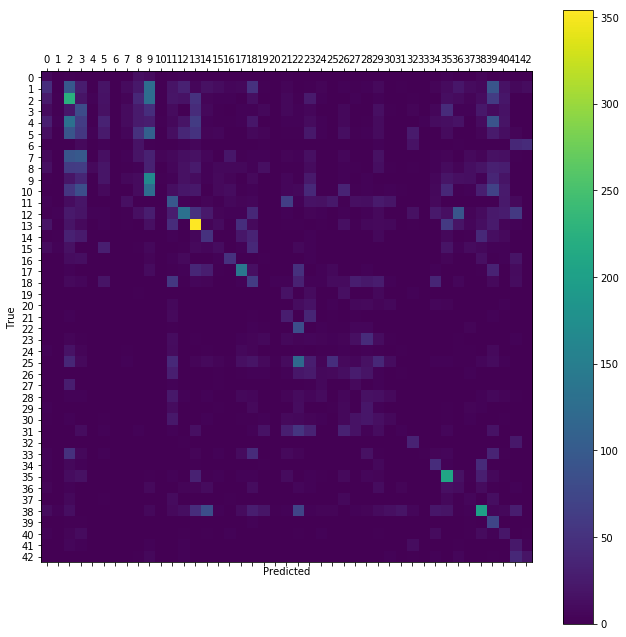

100


In [52]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

#### 1000 Iterations

In [53]:
optimize(num_iterations=900)

Optimization Iteration:    101, Training Accuracy:  25.0%
Optimization Iteration:    201, Training Accuracy:  56.2%
Optimization Iteration:    301, Training Accuracy:  64.1%
Optimization Iteration:    401, Training Accuracy:  76.6%
Optimization Iteration:    501, Training Accuracy:  75.0%
Optimization Iteration:    601, Training Accuracy:  82.8%
Optimization Iteration:    701, Training Accuracy:  89.1%
Optimization Iteration:    801, Training Accuracy:  90.6%
Optimization Iteration:    901, Training Accuracy:  92.2%
Time usage: 0:12:40


Accuracy on Test-Set: 76.4% (9644 / 12630)
Example errors:


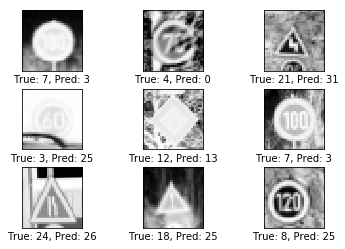

Confusion Matrix:
[[ 25   6   1 ...   0   0   0]
 [ 58 485  94 ...   9   0   0]
 [  6  33 601 ...   1   0   0]
 ...
 [ 11   1   1 ...  51   0   3]
 [  0   0   0 ...   0  40   8]
 [  0   0   0 ...   0   2  88]]


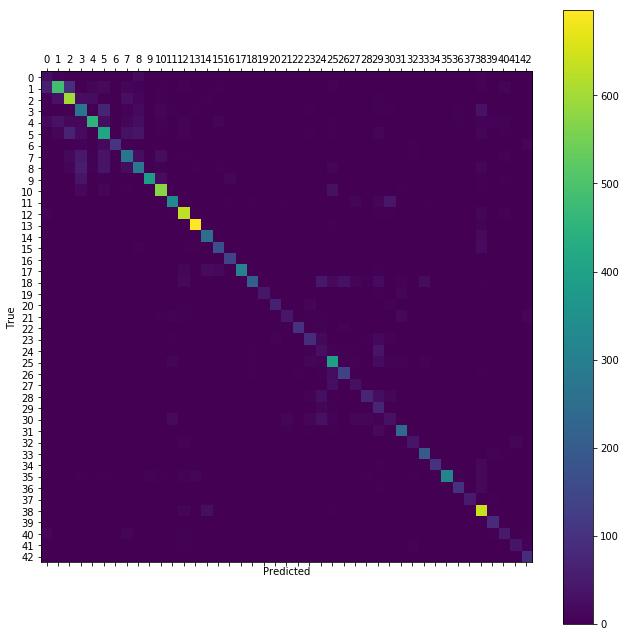

1000


In [54]:
print_test_accuracy(show_confusion_matrix=True, show_example_errors = True)
print(total_iterations)

#### 5000 Iterations

In [55]:
optimize(num_iterations=4000)

Optimization Iteration:   1001, Training Accuracy:  93.8%
Optimization Iteration:   1101, Training Accuracy: 100.0%
Optimization Iteration:   1201, Training Accuracy:  95.3%
Optimization Iteration:   1301, Training Accuracy:  92.2%
Optimization Iteration:   1401, Training Accuracy:  95.3%
Optimization Iteration:   1501, Training Accuracy:  92.2%
Optimization Iteration:   1601, Training Accuracy:  96.9%
Optimization Iteration:   1701, Training Accuracy:  95.3%
Optimization Iteration:   1801, Training Accuracy:  98.4%
Optimization Iteration:   1901, Training Accuracy:  95.3%
Optimization Iteration:   2001, Training Accuracy: 100.0%
Optimization Iteration:   2101, Training Accuracy:  98.4%
Optimization Iteration:   2201, Training Accuracy:  96.9%
Optimization Iteration:   2301, Training Accuracy: 100.0%
Optimization Iteration:   2401, Training Accuracy: 100.0%
Optimization Iteration:   2501, Training Accuracy:  98.4%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization I

Accuracy on Test-Set: 87.4% (11040 / 12630)
Confusion Matrix:
[[ 48  11   0 ...   0   0   0]
 [  9 662   8 ...   0   0   0]
 [  1  42 635 ...   6   0   0]
 ...
 [  0   4   1 ...  71   0   0]
 [  0   0   0 ...   0  49   0]
 [  0   0   0 ...   0   0  86]]


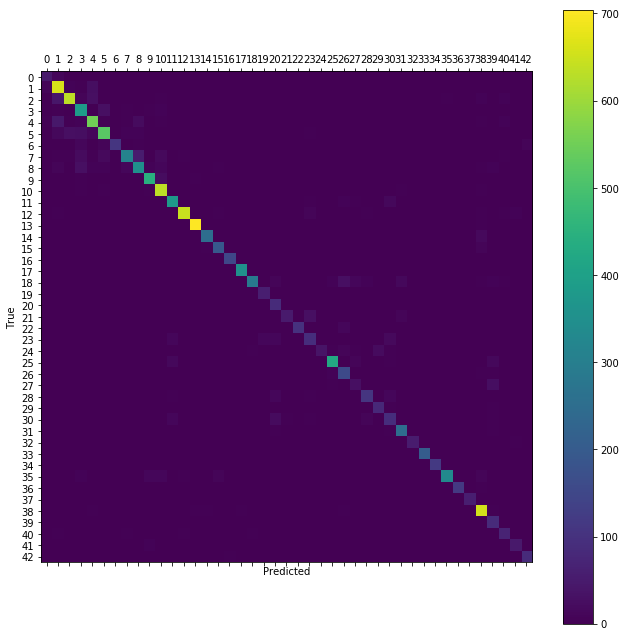

1000


In [48]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

#### 10000 Iterations

In [57]:
optimize(num_iterations=5000)

Optimization Iteration:   5001, Training Accuracy: 100.0%
Optimization Iteration:   5101, Training Accuracy:  98.4%
Optimization Iteration:   5201, Training Accuracy: 100.0%
Optimization Iteration:   5301, Training Accuracy: 100.0%
Optimization Iteration:   5401, Training Accuracy: 100.0%
Optimization Iteration:   5501, Training Accuracy: 100.0%
Optimization Iteration:   5601, Training Accuracy: 100.0%
Optimization Iteration:   5701, Training Accuracy: 100.0%
Optimization Iteration:   5801, Training Accuracy: 100.0%
Optimization Iteration:   5901, Training Accuracy:  98.4%
Optimization Iteration:   6001, Training Accuracy: 100.0%
Optimization Iteration:   6101, Training Accuracy: 100.0%
Optimization Iteration:   6201, Training Accuracy: 100.0%
Optimization Iteration:   6301, Training Accuracy: 100.0%
Optimization Iteration:   6401, Training Accuracy: 100.0%
Optimization Iteration:   6501, Training Accuracy: 100.0%
Optimization Iteration:   6601, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 91.5% (11558 / 12630)
Confusion Matrix:
[[ 58   1   0 ...   0   0   0]
 [ 15 684   2 ...   0   0   0]
 [  1  21 690 ...   0   0   0]
 ...
 [  5   0   0 ...  70   0   0]
 [  0   0   0 ...   0  47   0]
 [  0   0   0 ...   0   4  78]]


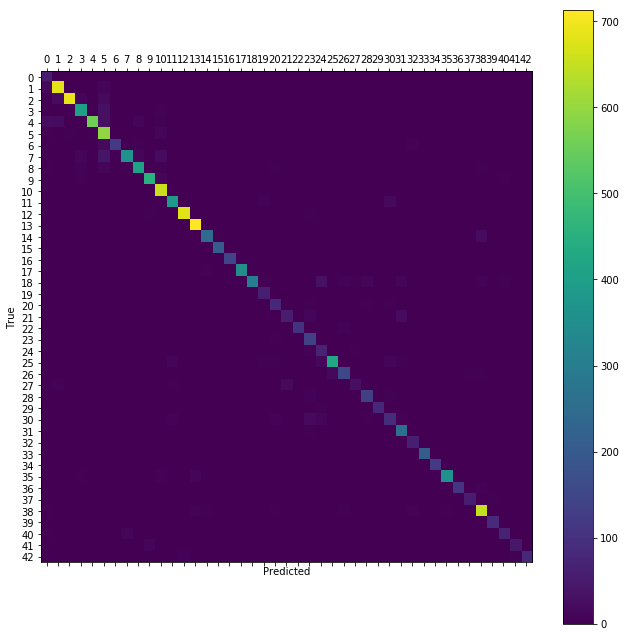

10000


In [58]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

#### 20000 Iterations

In [59]:
optimize(num_iterations=10000)

Optimization Iteration:  10001, Training Accuracy: 100.0%
Optimization Iteration:  10101, Training Accuracy: 100.0%
Optimization Iteration:  10201, Training Accuracy: 100.0%
Optimization Iteration:  10301, Training Accuracy: 100.0%
Optimization Iteration:  10401, Training Accuracy: 100.0%
Optimization Iteration:  10501, Training Accuracy: 100.0%
Optimization Iteration:  10601, Training Accuracy: 100.0%
Optimization Iteration:  10701, Training Accuracy:  98.4%
Optimization Iteration:  10801, Training Accuracy: 100.0%
Optimization Iteration:  10901, Training Accuracy: 100.0%
Optimization Iteration:  11001, Training Accuracy: 100.0%
Optimization Iteration:  11101, Training Accuracy:  98.4%
Optimization Iteration:  11201, Training Accuracy: 100.0%
Optimization Iteration:  11301, Training Accuracy: 100.0%
Optimization Iteration:  11401, Training Accuracy: 100.0%
Optimization Iteration:  11501, Training Accuracy: 100.0%
Optimization Iteration:  11601, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 93.8% (11851 / 12630)
Confusion Matrix:
[[ 51   1   0 ...   0   0   0]
 [  0 701   8 ...   0   0   0]
 [  0   4 726 ...   2   0   0]
 ...
 [  0   0   0 ...  72   0   0]
 [  0   0   0 ...   0  43   0]
 [  0   0   0 ...   0   1  79]]


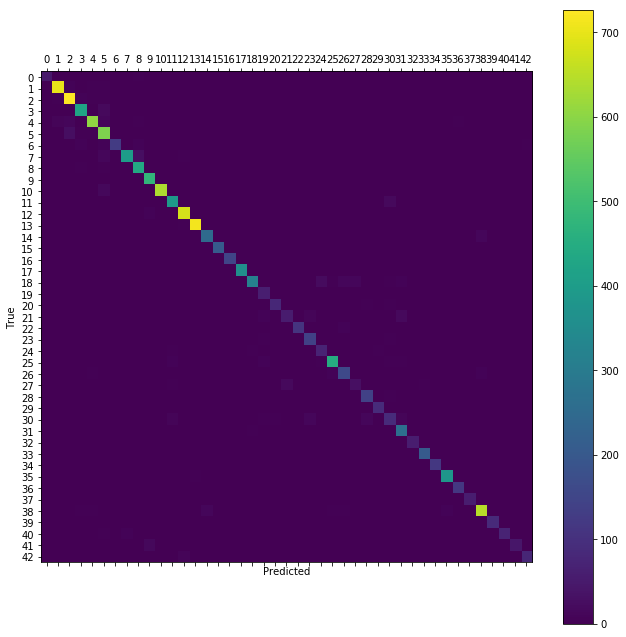

20000


In [60]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

#### 30000 Iterations

In [61]:
optimize(num_iterations=10000)

Optimization Iteration:  20001, Training Accuracy: 100.0%
Optimization Iteration:  20101, Training Accuracy: 100.0%
Optimization Iteration:  20201, Training Accuracy: 100.0%
Optimization Iteration:  20301, Training Accuracy: 100.0%
Optimization Iteration:  20401, Training Accuracy: 100.0%
Optimization Iteration:  20501, Training Accuracy: 100.0%
Optimization Iteration:  20601, Training Accuracy: 100.0%
Optimization Iteration:  20701, Training Accuracy: 100.0%
Optimization Iteration:  20801, Training Accuracy: 100.0%
Optimization Iteration:  20901, Training Accuracy: 100.0%
Optimization Iteration:  21001, Training Accuracy: 100.0%
Optimization Iteration:  21101, Training Accuracy: 100.0%
Optimization Iteration:  21201, Training Accuracy: 100.0%
Optimization Iteration:  21301, Training Accuracy: 100.0%
Optimization Iteration:  21401, Training Accuracy: 100.0%
Optimization Iteration:  21501, Training Accuracy: 100.0%
Optimization Iteration:  21601, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 94.1% (11889 / 12630)
Example errors:


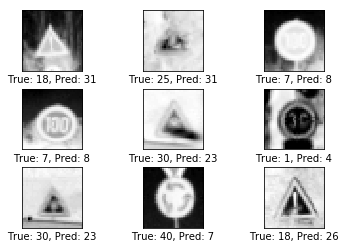

Confusion Matrix:
[[ 59   0   0 ...   0   0   0]
 [  0 697   5 ...   0   0   0]
 [  0   2 738 ...   0   0   0]
 ...
 [  0   1   0 ...  68   0   0]
 [  0   0   0 ...   0  53   0]
 [  0   0   0 ...   0   2  80]]


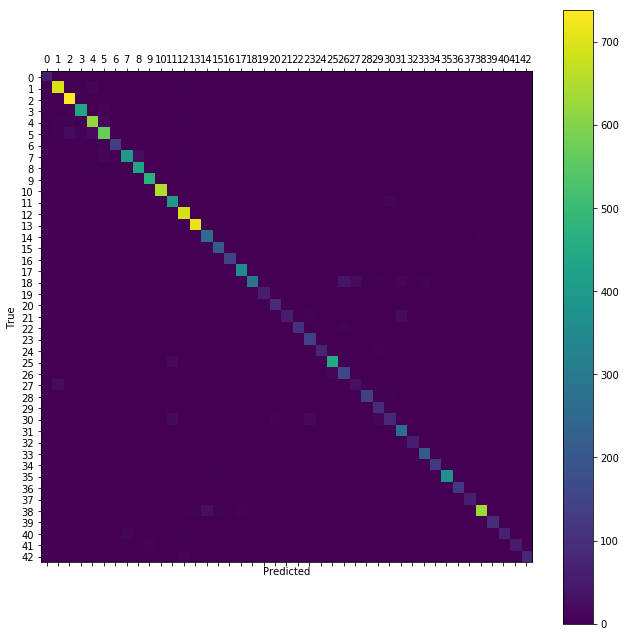

30000


In [62]:
print_test_accuracy(show_confusion_matrix=True, show_example_errors = True)
print(total_iterations)

#### 40000 Iterations

In [63]:
optimize(num_iterations=10000)

Optimization Iteration:  30001, Training Accuracy: 100.0%
Optimization Iteration:  30101, Training Accuracy: 100.0%
Optimization Iteration:  30201, Training Accuracy: 100.0%
Optimization Iteration:  30301, Training Accuracy: 100.0%
Optimization Iteration:  30401, Training Accuracy: 100.0%
Optimization Iteration:  30501, Training Accuracy: 100.0%
Optimization Iteration:  30601, Training Accuracy: 100.0%
Optimization Iteration:  30701, Training Accuracy: 100.0%
Optimization Iteration:  30801, Training Accuracy: 100.0%
Optimization Iteration:  30901, Training Accuracy: 100.0%
Optimization Iteration:  31001, Training Accuracy: 100.0%
Optimization Iteration:  31101, Training Accuracy: 100.0%
Optimization Iteration:  31201, Training Accuracy: 100.0%
Optimization Iteration:  31301, Training Accuracy: 100.0%
Optimization Iteration:  31401, Training Accuracy: 100.0%
Optimization Iteration:  31501, Training Accuracy: 100.0%
Optimization Iteration:  31601, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 94.2% (11902 / 12630)
Confusion Matrix:
[[ 60   0   0 ...   0   0   0]
 [  0 717   0 ...   0   0   0]
 [  1  10 705 ...   0   0   0]
 ...
 [  0   0   0 ...  76   0   2]
 [  0   0   0 ...   0  55   0]
 [  0   0   0 ...   0   2  83]]


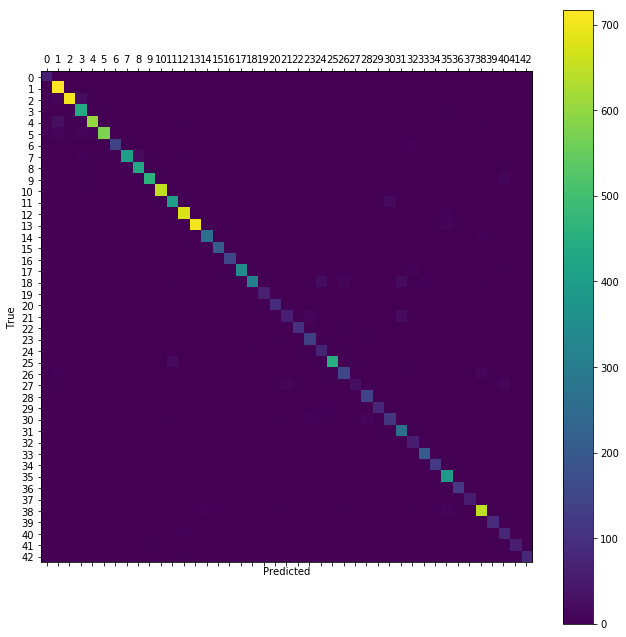

40000


In [65]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)